we use this snippet to display dataframes side by side:

In [0]:
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Part 2  
### Reminder- our goal is to predict the next hour total consumption ('Global_active_power') in assumption we have the last X history hours features.  
let's load the train data and prepare it to use for our goal:  
(we read the date as datetime format, in order to use resampling later.)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab inline 

train_data = pd.read_csv('train_data.csv',sep=',', parse_dates=['Date'], infer_datetime_format=True, index_col = ['Date'])

Populating the interactive namespace from numpy and matplotlib


In [0]:
train_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### fill missing values  
we will fill missing data by the mean of the same row (same time different days) of all the days before and after (that are not Nan). 

In [0]:
def calculate_mean(data,r,c):
    acc = 0
    z=r
    count=0
    r -= 24*60
    while(r>0):
        if not np.isnan(data[r,c]):
            acc += data[r,c]
            count += 1
        r -= 24*60
    z += 24*60
    while(z<data.shape[0]):
        if not np.isnan(data[z,c]):
            acc += data[z,c]
            count += 1
        z += 24*60
    return acc/count
        
    
def fill_missing_values(data):
    data = data.values
    for r in range(data.shape[0]):
        for c in range(data.shape[1]):
            if np.isnan(data[r,c]):
                data[r,c] = calculate_mean1(data,r,c)

In [0]:
fill_missing_values(train_data)

check that there is no more missing values:

In [0]:
train_data.isnull().any()

Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
Sub_metering_3           False
dtype: bool

the distribution has to be almost the same as in part 1:  
(this chart is helping has to ensure that 'fill_missing_values' worked correctly)

In [0]:
train_data.describe().transpose()[['count','min','max','mean','std']]

,count,min,max,mean,std
Global_active_power,1624716.0,0.076,11.122,1.103249,1.087804
Global_reactive_power,1624716.0,0.000,1.390,0.122139,0.111783
Voltage,1624716.0,223.200,254.150,240.692599,3.330322
Global_intensity,1624716.0,0.200,48.400,4.681047,4.573523
Sub_metering_1,1624716.0,0.000,82.000,1.162230,6.275138
Sub_metering_2,1624716.0,0.000,78.000,1.353865,5.994816
Sub_metering_3,1624716.0,0.000,31.000,6.260199,8.334372


let's save the data:

In [0]:
train_data.to_csv('data_without_nan.csv')

### rearrange the data by hours  
first we will use resample to group all the rows of the same hour and sum each feature consumption to one row that represent the one hour consumption.

In [0]:
train_data_by_hours = train_data.resample('H').sum()

In [0]:
train_data_by_hours.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


as we can see, each row in the dataframe represent an hour.

In [0]:
train_data_by_hours.describe().transpose()[['count','min','max','mean','std']]

,count,min,max,mean,std
Global_active_power,27079.0,7.440,393.632,66.193986,55.566029
Global_reactive_power,27079.0,1.262,46.460,7.328227,4.020609
Voltage,27079.0,8447.180,15114.120,14441.342638,189.326071
Global_intensity,27079.0,30.200,1703.000,280.858643,232.739047
Sub_metering_1,27079.0,0.000,2902.000,69.732769,216.992509
Sub_metering_2,27079.0,0.000,2786.000,81.230705,260.229121
Sub_metering_3,27079.0,0.000,1227.000,375.606410,436.944765


### split the train data to train and validation sets.  

by this function we will save and load the data:

In [0]:
import pickle
def save_obj(obj,path):
    with open(path + '.pkl', "wb") as output:
        pickle.dump(obj, output)
def load_obj(path):
    with open(path + '.pkl', "rb") as output:
        return pickle.load(output)

we will use 80% from the data for training, and 20% for validation. because it is time series data we will not use any shuffle methods.

In [0]:
split = 0.8
q = round(split*len(train_data_by_hours))
train = train_data_by_hours[:q]
save_obj(train,'splited_data/train')
validation = train_data_by_hours[q:]
save_obj(validation,'splited_data/validation')

In [0]:
train.shape,validation.shape

((21663, 7), (5416, 7))

notice that there are 21663 hours in the training set and 5416 in the validation set.

### how we evaluate our model?  
in order to evaluate our model and compare between different models we have to decide about 1 numeric value that represent our model quality. we will do it by rmse.

In [0]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

def rmse(actual,predicted):
    return sqrt(mse(actual,predicted))

### series to supervised

as we studied at lecture we have to convert the data from series data (sequences) , to supervised data in consider to our research question. in our case we have to take X sequences, and label them with the X+1 sequence column 'Global_active_power'. in this case, we decided not to use horizon. 

In [0]:
def to_supervised(data, n_input, n_out=1):
    X,Y = list(),list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data.iloc[in_start:in_end,:].values)
            Y.append(data.iloc[in_end:out_end,0].values[0])
        # move along one time step
        in_start += 1
    return X,Y

### normalize  
we have to normalize the validation and test data with the same parameters as the train data, we will do that by min max normalization with the following method:

In [0]:
def normalize(train,test):
    normalized_data = pd.DataFrame.copy(test)
    for i in normalized_data.columns[:]:
        normalized_data[i] = (normalized_data[i] - train[i].min()) / (train[i].max() - train[i].min())
    return normalized_data

In [0]:
train_normalized = normalize(train, train)
validation_normalized = normalize(train, validation)

In [0]:
train_normalized.describe().transpose()[['count','min','max','mean','std']]

,count,min,max,mean,std
Global_active_power,21663.0,0.0,1.0,0.155583,0.147516
Global_reactive_power,21663.0,0.0,1.0,0.150192,0.101190
Voltage,21663.0,0.0,1.0,0.896260,0.029005
Global_intensity,21663.0,0.0,1.0,0.153277,0.142887
Sub_metering_1,21663.0,0.0,1.0,0.024646,0.076123
Sub_metering_2,21663.0,0.0,1.0,0.030631,0.098159
Sub_metering_3,21663.0,0.0,1.0,0.306640,0.364152


we can notice that 'Global_active_power' values range are between [0,1] , the reason we pay attention to it , is in order to understand which values are reasonable for RMSE.

## Building machine learning for our goal

we will make the following steps in order to build and evaluate different machine learning and understand which one is the best:  
* each ml train on the train set.
* for each ml there are different parameters we can tune, in order to evaluate the best model among them, we will use the validation set. (so there is dependency between the model and the parameter we try to tune)
* after we choose the best tuning parameter, we want to evaluate the model with data that there is not any dependency between the model and the data, for this purpose we will use the test set.  
  
  
the train and validation set are ready to use let's do the same process with the test set:

In [0]:
test_data = pd.read_csv('test_data.csv',sep=',', parse_dates=['Date'], infer_datetime_format=True, index_col = ['Date'])

In [0]:
test_data.isnull().any()

Global_active_power      True
Global_reactive_power    True
Voltage                  True
Global_intensity         True
Sub_metering_1           True
Sub_metering_2           True
Sub_metering_3           True
dtype: bool

In [0]:
fill_missing_values(test_data)

In [0]:
test_data.isnull().any()

Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
Sub_metering_3           False
dtype: bool

In [0]:
test_data_by_hours = test_data.resample('H').sum()

In [0]:
test_data_normalized = normalize(train,test_data_by_hours)

## Naive baseline

in order to create naive baseline model we have to choose a rule, we chose the following rule: 'our next hour prediction ('Global active power') will be the mean of X last hour global active power', the following baseline rule will do that:

In [0]:
def baseline_rule(data):
    sum = 0
    for el in data:
        sum += el[0]
    return sum/len(data)

let's try to predict by using the last 9 hours for prediction:

In [0]:
n_in = 8
X,Y = to_supervised(validation_normalized,n_in)
prediction=[]
for x in X:
    prediction.append(baseline_rule(x))
rmse(Y,prediction)

0.13098081870169129

as we can see the result is not bad for baseline, the rmse is ~0.131 and the values range is between [0,1].  
because for baseline model we are satisfied with this result we will not try to check if with different n_in parameter (number of history hours). but we have to check the result on our test set, because on this set we will examine our benchmark:

In [0]:
X,Y = to_supervised(test_data_normalized,n_in)
prediction=[]
for x in X:
    prediction.append(baseline_rule(x))
rmse(Y,prediction)

0.12071760352169737

as we can see that there is a little gap between the results , but because it's naive baseline this will not bother us for now. if in our next ml model we will get results with bigger gap we will have to check our split to validation set cause probably it is not depict the test set well.  
*** our baseline benchmark is 0.1200 ***

## Classic ML

we will use the following functions in order to use classical models and compare between them:  
(we use flatten in order to convert each X hours with shape (X,7) to 1 dim with 7X elements  
 we use classic_ml to fit and predict classic ml.  
 we use ml_by_history to return the best model trained by classic_ml and plot summary)

In [0]:
def flatten(data):
    flatten_data = []
    for el in data:
        flatten_data.append(el.ravel())
    return flatten_data

In [0]:
from copy import deepcopy
def classic_ml(clf, n_in):
    train_X,train_Y = to_supervised(train_normalized,n_in)
    validation_X,validation_Y = to_supervised(validation_normalized,n_in)
    flatten_validation_x = flatten(validation_X)
    flatten_train_x = flatten(train_X) 
    # training
    clf = clf.fit(flatten_train_x,train_Y)
    # prediction
    pred = clf.predict(flatten_validation_x)
    root_mse = rmse(validation_Y,pred)
    return clf, root_mse

def ml_by_history(n_in_lst,regressor):
    min = float('inf')
    res = []
    modle_ml = None
    q = -1
    for n_in in n_in_lst:
        m,score = classic_ml(regressor, n_in)
        res.append(score)
        if min > score:
            modle_ml = deepcopy(m)
            min = score
            q = n_in
    plot(n_in_lst,res)
    plt.xlabel('n_in')
    plt.ylabel('rmse')
    plt.title('rmse as function of number of history hours')
    print('\n*** BEST RESULT WITH {} HISTORY hours WITH RMSE OF: {} ***'.format(q,min))
    return min,modle_ml

we will train linearegression:

In [0]:
from sklearn.linear_model import LinearRegression
rgr = LinearRegression()
rgr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

this model is very simple and there are not many parameters, hence we dont have to do any tuning with the model parameters, but we will try to check with how many history hours we can get the most accurate and generalize model, in the following function we will check for the best model with history hours between 1 to 48:


*** BEST RESULT WITH 47 HISTORY hours WITH RMSE OF: 0.07923576894493851 ***


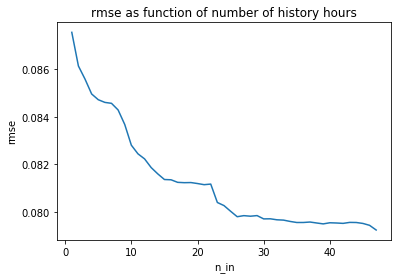

In [0]:
min_rmse,model = ml_by_history([i for i in range(1,48)],rgr)

we have got great result on the validation set, but the validation set is depend on the n_in parameter, let's try to calculate the rmse on the test set:

In [0]:
n_in = 47
X,Y = to_supervised(test_data_normalized,n_in)
pred = model.predict(flatten(X))
rmse(Y,pred)

0.11974072078110307

the result on the test set is almost the same as in the validation set.  
and *** we have got a new benchmark of ~0.1197 RMSE ***

let's try the same process on different model, now will will try to use LassoLars:

In [0]:
from sklearn import linear_model
reg = linear_model.LassoLars()


*** BEST RESULT WITH 33 HISTORY hours WITH RMSE OF: 0.12853364255653654 ***


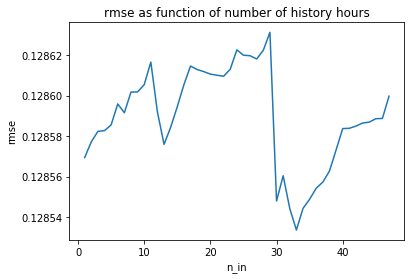

In [0]:
min_rmse_lasso,model_lasso = ml_by_history([i for i in range(1,48)],reg)

In [0]:
n_in = 33
X,Y = to_supervised(test_data_normalized, n_in)
pred = model_lasso.predict(flatten(X))
rmse(Y,pred)

0.12226921931275868

the result we have got for Lasso model is not better than the result we have got for LinearRegression.

## FORM NN

import relevant packages:

In [0]:
from keras.layers import Dense,LSTM,Input,Dropout,Conv1D,Flatten,Activation
from keras.models import Model

this function will return list of callbacks to use:

In [0]:
from keras.callbacks import *
import os
def set_callbacks(description='normal', path = './', patience=3):
    path += description + '/'
    try:
        os.mkdir(path)
    except FileExistsError:
        None
    cp = ModelCheckpoint(path + 'weights.{epoch:02d}-{val_loss:.2f}_'+ description + '.hdf5',save_best_only=True)
    #cp = ModelCheckpoint(path + 'best_weights.hdf5',save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='loss')   
    log = CSVLogger(path + 'train_log.csv')
    tb = TensorBoard(log_dir=path + 'logs/')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss',factor=0.1, patience=2, verbose=1, epsilon=1e-3)
    cb = [reduce_lr_loss,cp,es]
    return cb

our first model will be very simple, we will use only one hidden layer. because this is time series data, we chose to use lstm layer as our hidden layer with 30 units.

In [0]:
def build_nn_model(n_in,n_out,n_vars,units=30):
    inp = Input(shape=(n_in,n_vars))
    x = LSTM(units)(inp)
    output = Dense(n_out)(x)
    model = Model(inp,output)
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.summary()
    return model

here we also use 47 hours history as we used in the classic model. (because it gave us the best result there)  
with 10 epochs and batch size of 32.

In [0]:
n_in=47
n_out=1
n_vars=train_normalized.shape[1]

# series to supervised
validation_X,validation_Y = to_supervised(validation_normalized,n_in)
train_X,train_Y = to_supervised(train_normalized,n_in)

# build NN model
model = build_nn_model(n_in,n_out,n_vars)

# fit the model
history = model.fit(np.asarray(train_X),np.asarray(train_Y),validation_data=[np.asarray(validation_X),np.asarray(validation_Y)],
                    callbacks = set_callbacks(patience=5, path='./models_weights/' , description='_first1'),epochs=10,batch_size=32) 

# prediction & RMSE
nn_pred = model.predict(np.asarray(validation_X))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 47, 7)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                4560      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 4,591
Trainable params: 4,591
Non-trainable params: 0
_________________________________________________________________
Train on 21615 samples, validate on 5368 samples
Epoch 1/10
21615/21615 [==============================] - 28s 1ms/step - loss: 0.0135 - val_loss: 0.0080
Epoch 2/10
21615/21615 [==============================] - 25s 1ms/step - loss: 0.0098 - val_loss: 0.0069
Epoch 3/10
21615/21615 [==============================] - 25s 1ms/step - loss: 0.0092 - val_loss: 0.0066
Epoch 4/10
21615/21615 [================

save the history, so we can later plot the loss:

In [0]:
save_obj(history.history,'./models_weights/_first1/history')

this function will get an history and print the loss of the validation and train sets:

In [0]:
def plot_loss(history):
    plot([i for i in range(len(history['loss']))],history['loss'])
    plot([i for i in range(len(history['val_loss']))],history['val_loss'])
    valid_set = mpatches.Patch(color='orange', label='validation')
    train_set = mpatches.Patch(color='blue', label='train')
    plt.legend(handles=[valid_set,train_set])
    plt.xlabel('n_in')
    plt.ylabel('rmse')
    plt.title('rmse as function of number of history days')

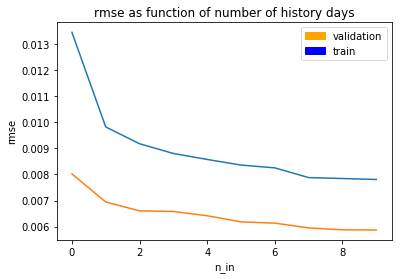

In [0]:
plot_loss(load_obj('./models_weights/_first1/history'))

*** important facts about the plot ***
* the model has 4,591 parameters, and 21,623 samples to train on.
* we can see that as the epoch advanced the train loss decrease, the same happend in the validation set (except epoch 3).
* the loss of the validation set is lower than the train set since the first epoch, and as the number of epoch increase the train set loss decrease, and the vlidation set decrease as well.  
* we have got an intersting case , which the model fit better to the validation than to the training set, it can happen sometimes and it is not planned, but because we can notice that while the train set fit better, the validation loss decrease and because of the explanation below this case doesn't bother us.

*** let's take a look where we had bad prediction: ***  
if we look at the input and output it's all numeric and this is very difficult for us to understand patterns in this way, hence we use the following function in order to display summary tables, the threshold parameter meaning is 'which error above the rmse we will consider as high enough to conclude in the summary':

In [0]:
def analyze_result(model,path,n_in,data = test_data_normalized,threshold = 0.2):
    X,Y = to_supervised(data,n_in)
    model.load_weights(path)
    score = rmse(Y,model.predict(np.asarray(X)))
    to_check = []
    for i,el in enumerate(X[0:-1]):
        if rmse(Y[i:i+1],model.predict(np.asarray(X[i:i+1]))) > score + threshold:
            to_check.append(i + n_in)
    counts_by_hour = pd.DataFrame(pd.Series(test_data_normalized.iloc[to_check,:].index.hour.values).value_counts()).reset_index()
    counts_by_hour.columns = ['hour','count']
    pm = counts_by_hour['hour'] > 12
    counts_by_ampm = pd.DataFrame([counts_by_hour[pm]['count'].sum(),counts_by_hour[[not i for i in pm]]['count'].sum()],['pm','am'])
    counts_by_day = pd.Series([calendar.day_name[my_date.weekday()] for my_date in test_data_normalized.iloc[to_check,:].index]).value_counts().reset_index()
    counts_by_day.columns = ['day','count']
    display(counts_by_hour)
    display(counts_by_ampm)
    display(counts_by_day)

In [0]:
n_in=47; path = './models_weights/_first1/best_weights.hdf5'
analyze_result(model,path,n_in)

,hour,count
0,19,10
1,20,7
2,18,7
3,12,6
4,10,5
5,21,4
6,11,4
7,15,3
8,14,3
9,22,2


,0
pm,41
am,19


,day,count
0,Saturday,12
1,Monday,12
2,Sunday,11
3,Wednesday,9
4,Thursday,7
5,Tuesday,7
6,Friday,2


we want to pay attention to the following facts:  
* in the summary only errors that get 0.2 above the rmse included. (60 errors)
* most of them occoured during the evening time. (41/60 => ~68%)
* a large number of the mistakes occoured during the days saturday and sunday. (~38%)  
  
  what can we infer from this ?  
Unfortunately, we do not know from which house the data is taken and how many people are living at home, and it make it difficult for us to understand the electricity consumption habits of the family members. by the facts we mentioned, most of the errors are during the evening, and in the weekend, so probably we can infer from it that during the day and in the middle of the week most of the time the family members at school, job and etc, so the consumption patterns in these hours are easy to learn. but at the evening and weekend time, they spend more time at home, use electricity often the the consumption pattern is more complex because of these reasons.

let's see the RMSE on the validation set:

In [0]:
model.load_weights('./models_weights/_first1/best_weights.hdf5')
nn_pred = model.predict(np.asarray(validation_X))
rmse(validation_Y,nn_pred)

0.0765920460634663

it looks like we have got better result with nn, but for this result we tuned with different batch_size and units (we run the model couple of times before this running) so the result depend on this parameters.  
let's check the rmse on the test set:

In [0]:
X,Y = to_supervised(test_data_normalized,n_in)
rmse(Y,model.predict(np.asarray(X)))

0.07969866897171837

***we have got new benchmark, by improving the rmse to 0.0797 ***

# * Explanation about the phenomenon that the train loss is higher than the validation loss *

while we trained this nn we were very surprising to see the the train loss is higher than the validation loss during all the training process.  
first thing we did is using 'Three fingers rule' in order to guess why this happens, we thought about the following reasons:  
** our split was not good enough ** - because probably the train set has more 'difficult' cases that the model has to learn, and the validation set doesn't consist them, so the validation consist only the easy cases that the model learn very easy, and hence the loss rate for the validation is lower.  
what we did?  
we thought maybe there is really difficult cases which can result from transition season, holidays, and many other reasons, and because the validation set cover only few months probably some of this cases doesn't appear there, so we tried to split the train and validation in a different way so the validation will cover one year. the reason for this split is that in the exploration we saw that over the years the use in electricity was similar. the result of this try, was the same, and the train loss was still higher than the validation loss during the train.  
** because the train set is bigger than the validation set the loss is higher ** - we calculate the loss by mse which means MEAN square error, so because it mean the square error this assumption is not logical.  
** the loss of the train set every epoch is calculated before the gradients have been applied while the validation loss calculated after the gradients have been applied **  
what we did?  
we decided to try to train the model and use our train set also for validation, if we will see that the validation loss is less than the train loss we can conclude that this assumption is right.  
the following snippet do this:


In [0]:
n_in=47
n_out=1
n_vars=train_normalized.shape[1]
# series to supervised
validation_X,validation_Y = to_supervised(validation_normalized,n_in)
train_X,train_Y = to_supervised(train_normalized,n_in)
# build NN model
model = build_nn_model(n_in,n_out,n_vars)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 47, 7)             0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 30)                4560      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 31        
Total params: 4,591
Trainable params: 4,591
Non-trainable params: 0
_________________________________________________________________


In [0]:
# fit the model
history = model.fit(np.asarray(train_X),np.asarray(train_Y),validation_data=[np.asarray(train_X),np.asarray(train_Y)],
                    callbacks = set_callbacks(patience=5, path='./models_weights/' , description='_first1'),epochs=3,batch_size=32) 

Train on 21615 samples, validate on 21615 samples
Epoch 1/3
21615/21615 [==============================] - 34s 2ms/step - loss: 0.0128 - val_loss: 0.0098
Epoch 2/3
21615/21615 [==============================] - 28s 1ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 3/3
21615/21615 [==============================] - 27s 1ms/step - loss: 0.0090 - val_loss: 0.0087


as we can see this assumption is right!! 
*** and we learned something new :) ***  
conclusion about our data:  
probably usually when we use nn the data is more varied so the updated weights (after gradient) are not good enough to describe the validation data better than the train data before gradient applied, in our case the data is almost not varied, so after gradient applied the loss of the validation is lower than train loss before the weights updated.

we also found famouse tutorial by lasagne with mnist dataset, there same situation happend (https://lasagne.readthedocs.io/en/latest/user/tutorial.html).

### Three Finger Rule (at least three...)  
so... how can we improve our nn model?  
* we can try to add more units to the LSTM layer or add new layers to increase the number of parameters, in order to fit the train data even more.  
* we can make our nn model deeper and see if it is helping (as we saw in lectures the deeper the layer, the more complex patterns it learns).  
* we can try to change n_in value, possibly with different value the model can generelize better.
* we can try feature engineering by adding new column for the 'active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.' as new feature as we saw in the exploration.
* we can try to use CNN layers in order to try to recognize the structure of data.  
* we can also try to change the batch_size. (we read some articles that using mini-batch can increase the generalization)  
* we can try to use feature extraction with cnn (as we saw in lecture, this will be good idea in case cnn will give us good result, so it recognize patterns in the data, and we can use this patterns as features)  
  
by these steps we can maybe fit the data better and recognize complex patterns in the data even during the evening and weekend time.

### feature engineering  
first we will try feature engineering by adding new feature.  
'Sub_metering_4' that represents the active energy consumed every minute (in watt) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.  
the following function return train,validation sets with the new feature:

In [0]:
def add_sub_metering_4():
    #train_data = pd.read_csv('train_data.csv',sep=',', parse_dates=['Date'], infer_datetime_format=True, index_col = ['Date'])
    data = pd.read_csv('data_without_nan.csv',  parse_dates=['Date'], infer_datetime_format=True, index_col = ['Date'])
    data['Sub_metering_4'] = data['Global_active_power']*1000/60 - data['Sub_metering_1'] - data['Sub_metering_2'] - data['Sub_metering_3']
    data_by_days = data.resample('H').sum()
    split = 0.8
    q = round(split*len(data_by_days))
    _train = data_by_days[:q]
    _validation = data_by_days[q:]
    #normalization
    train = normalize(_train,_train)
    validation = normalize(_train,_validation)
    return train,validation

In [0]:
train_1_more_feature, validation_1_more_feature = add_sub_metering_4() 

we use the same nn as before, one hiddem layer of LSTM with 30 units: 

In [0]:
n_in=47
n_out=1
n_vars=train_1_more_feature.shape[1]

# series to supervised
validation_X,validation_Y = to_supervised(validation_1_more_feature,n_in)
train_X,train_Y = to_supervised(train_1_more_feature,n_in)

# build NN model
model = build_nn_model(n_in,n_out,n_vars)

# fit the model
history = model.fit(np.asarray(train_X),np.asarray(train_Y),validation_data=[np.asarray(validation_X),np.asarray(validation_Y)],
                    callbacks = set_callbacks(patience=5, path='./models_weights/' , description='_feature_engineering'), batch_size = 32 ,epochs=15) 

# prediction & RMSE
nn_pred = model.predict(np.asarray(validation_X))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 47, 8)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                4680      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 4,711
Trainable params: 4,711
Non-trainable params: 0
_________________________________________________________________
Train on 21615 samples, validate on 5368 samples
Epoch 1/15
21615/21615 [==============================] - 25s 1ms/step - loss: 0.0132 - val_loss: 0.0073
Epoch 2/15
21615/21615 [==============================] - 23s 1ms/step - loss: 0.0093 - val_loss: 0.0069
Epoch 3/15
21615/21615 [==============================] - 23s 1ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 4/15
21615/21615 [================

save the history:

In [0]:
save_obj(history.history,'./models_weights/_feature_engineering/history')

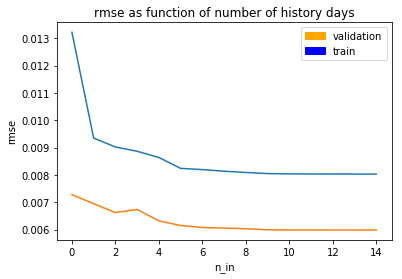

In [0]:
plot_loss(history.history)

as we can see this plot is almost similar to the last plot, we can notice that from epoch 6, the loss is constant in both the train and validation sets. we can also notice that when the model fit better the train the validation loss decrease, hence if we success to fit the model even better than now we probably can get even better result. (because by this fact we can notice that there is not overfit although the train loss is low). 

calculate RMSE on validation set:

In [0]:
model.load_weights('./models_weights/_feature_engineering/best_weights.hdf5')
nn_pred = model.predict(np.asarray(validation_X))
rmse(validation_Y,nn_pred)

0.07734512789782645

we can notice that the result are not better than it was with 7 features (on the validation set).  
we can also see that the train loss is higher than it was, so we will try to fit this data set (with 8 features) with a little bit more parameters and see if there will be any improvement:

In [0]:
n_in=47
n_out=1
n_vars=train_1_more_feature.shape[1]

# series to supervised
validation_X,validation_Y = to_supervised(validation_1_more_feature,n_in)
train_X,train_Y = to_supervised(train_1_more_feature,n_in)

# build NN model
model = build_nn_model(n_in,n_out,n_vars,50)

# fit the model
history = model.fit(np.asarray(train_X),np.asarray(train_Y),validation_data=[np.asarray(validation_X),np.asarray(validation_Y)],
                    callbacks = set_callbacks(patience=5, path='./models_weights/' , description='_feature_engineering_more_units'), batch_size = 32 ,epochs=15) 

# prediction & RMSE
nn_pred = model.predict(np.asarray(validation_X))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 47, 8)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                11800     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
Train on 21615 samples, validate on 5368 samples
Epoch 1/15
21615/21615 [==============================] - 27s 1ms/step - loss: 0.0111 - val_loss: 0.0069
Epoch 2/15
21615/21615 [==============================] - 24s 1ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 3/15
21615/21615 [==============================] - 24s 1ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 4/15
21615/21615 [==============

In [0]:
save_obj(history.history,'./models_weights/_feature_engineering_more_units/history')

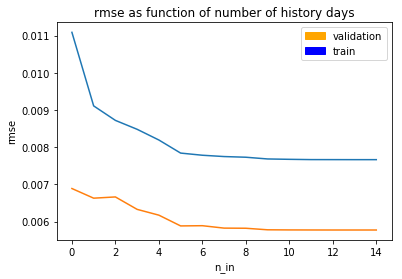

In [0]:
plot_loss(load_obj('./models_weights/_feature_engineering_more_units/history'))

there is nothing speecial to notice about this plot, just to see that until epoch 5 the train and validation sets loss decreses fast and later it was moderatly until constant. 

In [0]:
model.load_weights('./models_weights/_feature_engineering_more_units/best_weights.hdf5')
nn_pred = model.predict(np.asarray(validation_X))
rmse(validation_Y,nn_pred)

0.07597617785683672

it seems that we improved our last benchmark, to get this result we train our model with both 16 and 32 batch size, and at the end we decided 32 is better, because we have got better result, but this result depend on batch size parameter, let's check it on the test set:

In [0]:
test1 = pd.read_csv('test_data.csv',sep=',', parse_dates=['Date'], infer_datetime_format=True, index_col = ['Date'])
fill_missing_values(test1)
train_2 = pd.DataFrame.copy(train)
train_2['Sub_metering_4'] = train_2['Global_active_power']*1000/60 - train_2['Sub_metering_1'] - train_2['Sub_metering_2'] - train_2['Sub_metering_3']
test1['Sub_metering_4'] = test1['Global_active_power']*1000/60 - test1['Sub_metering_1'] - test1['Sub_metering_2'] - test1['Sub_metering_3']
test1_by_hours = test1.resample('H').sum()
test1_n = normalize(train_2,test1_by_hours)

In [0]:
test1_n.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Date,,,,,,,,
2010-01-18 00:00:00,0.203572,0.176557,0.924190,0.191774,0.0,0.011486,0.936205,0.049779
2010-01-18 01:00:00,0.177912,0.061240,0.920817,0.167623,0.0,0.000000,0.842585,0.044483
2010-01-18 02:00:00,0.025858,0.061292,0.930022,0.025466,0.0,0.000000,0.033140,0.044036
2010-01-18 03:00:00,0.034548,0.197199,0.941867,0.035390,0.0,0.014358,0.033969,0.047958
2010-01-18 04:00:00,0.026526,0.070981,0.930182,0.026064,0.0,0.000000,0.033140,0.045166


In [0]:
X,Y = to_supervised(test1_n,n_in)
rmse(Y,model.predict(np.asarray(X)))

0.07631254844544175

as we can see the rmse for the test set is higher than the rmse for the validation set, but still we have got a little improvement. *** so our new benchmark is 0.0763 *** we don't consider this improvement to the new feature because it is really negligibal, and we also try to train the data with 7 features with more units and got same result, so we will continue with 7 features.

*** let's understand the errors better ***  
the rmse lower than in the last benchmark, now we will use the same default threshold (0.2) and look at the results:

In [0]:
n_in=47; path = './models_weights/_feature_engineering_more_units/best_weights.hdf5'
analyze_result(model,path,n_in,test1_n)

,hour,count
0,19,8
1,18,7
2,12,7
3,10,5
4,20,4
5,14,3
6,21,3
7,11,3
8,17,2
9,15,2


,0
pm,34
am,20


,day,count
0,Saturday,12
1,Monday,11
2,Sunday,10
3,Wednesday,9
4,Thursday,6
5,Tuesday,3
6,Friday,3


* we have 54 errors above the threshold.
* 32 of them occoured during the day (pm), this is ~63%.
* 22 of them occoured during the weekend (saturday,sunday), ~40%

## best n_in

we will try to fit our model with different n_in (amount of history days) and check with which value we get the best result:

In [0]:
def nn_by_history_in(n_in_lst,_path,_description):
    best_model = None
    min = float('inf')
    q = -1
    res = []
    n_out=1
    for n_in in n_in_lst:
        n_vars=validation_normalized.shape[1]

        # series to supervised
        validation_X,validation_Y = to_supervised(validation_normalized,n_in)
        train_X,train_Y = to_supervised(train_normalized,n_in)

        # build NN model
        model = build_nn_model_v1_more_units(n_in,n_out,n_vars)

        # fit the model
        history = model.fit(np.asarray(train_X),np.asarray(train_Y),validation_data=[np.asarray(validation_X),np.asarray(validation_Y)],
                            callbacks = set_callbacks(patience=3, path=_path , description=_description + '_' + str(n_in)),epochs=14, batch_size=32) 

        # prediction & RMSE
        model.load_weights(_path + _description + '_' + str(n_in) + '/best_weights.hdf5')
        nn_pred = model.predict(np.asarray(validation_X))
        score = sqrt(mse(validation_Y,nn_pred))
        res.append(score)
        if min > score:
            min = score
            best_model = deepcopy(model)
            q = n_in
    print('\n*** BEST RESULT WITH {} HISTORY HOURS WITH RMSE OF: {} ***'.format(q,min))
    plot(n_in_lst,res)
    plt.xlabel('n_in')
    plt.ylabel('rmse')
    plt.title('rmse as function of number of history hours')
    return res,model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        (None, 1, 7)              0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 50)                11600     
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________
Train on 21661 samples, validate on 5414 samples
Epoch 1/14
21661/21661 [==============================] - 17s 796us/step - loss: 0.0113 - val_loss: 0.0082
Epoch 2/14
21661/21661 [==============================] - 5s 214us/step - loss: 0.0100 - val_loss: 0.0077
Epoch 3/14
21661/21661 [==============================] - 5s 208us/step - loss: 0.0099 - val_loss: 0.0078
Epoch 4/14
21661/21661 [==========

Epoch 10/14
21655/21655 [==============================] - 7s 333us/step - loss: 0.0088 - val_loss: 0.0067
Epoch 11/14
21600/21655 [============================>.] - ETA: 0s - loss: 0.0088
Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
21655/21655 [==============================] - 7s 318us/step - loss: 0.0088 - val_loss: 0.0067
Epoch 12/14
21655/21655 [==============================] - 7s 335us/step - loss: 0.0088 - val_loss: 0.0067
Epoch 13/14
21536/21655 [============================>.] - ETA: 0s - loss: 0.0088
Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
21655/21655 [==============================] - 7s 332us/step - loss: 0.0088 - val_loss: 0.0067
Epoch 14/14
21655/21655 [==============================] - 8s 348us/step - loss: 0.0088 - val_loss: 0.0067
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        (No

21637/21637 [==============================] - 16s 755us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 5/14
21600/21637 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21637/21637 [==============================] - 20s 935us/step - loss: 0.0083 - val_loss: 0.0063
Epoch 6/14
21637/21637 [==============================] - 17s 765us/step - loss: 0.0080 - val_loss: 0.0060
Epoch 7/14
21637/21637 [==============================] - 16s 762us/step - loss: 0.0080 - val_loss: 0.0060
Epoch 8/14
21637/21637 [==============================] - 16s 757us/step - loss: 0.0079 - val_loss: 0.0060
Epoch 9/14
21600/21637 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
21637/21637 [==============================] - 16s 760us/step - loss: 0.0079 - val_loss: 0.0059
Epoch 10/14
21637/21637 [==============================] - 16s 760u

Train on 21628 samples, validate on 5381 samples
Epoch 1/14
21628/21628 [==============================] - 37s 2ms/step - loss: 0.0132 - val_loss: 0.0076
Epoch 2/14
21628/21628 [==============================] - 22s 1ms/step - loss: 0.0096 - val_loss: 0.0069
Epoch 3/14
21628/21628 [==============================] - 22s 1ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 4/14
21628/21628 [==============================] - 22s 1ms/step - loss: 0.0086 - val_loss: 0.0064
Epoch 5/14
21628/21628 [==============================] - 21s 952us/step - loss: 0.0084 - val_loss: 0.0061
Epoch 6/14
21628/21628 [==============================] - 21s 967us/step - loss: 0.0083 - val_loss: 0.0060
Epoch 7/14
21628/21628 [==============================] - 21s 967us/step - loss: 0.0081 - val_loss: 0.0061
Epoch 8/14
21568/21628 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21628/21628 [==============================] - 2

Train on 21619 samples, validate on 5372 samples
Epoch 1/14
21619/21619 [==============================] - 40s 2ms/step - loss: 0.0118 - val_loss: 0.0072
Epoch 2/14
21619/21619 [==============================] - 27s 1ms/step - loss: 0.0092 - val_loss: 0.0064
Epoch 3/14
21619/21619 [==============================] - 27s 1ms/step - loss: 0.0086 - val_loss: 0.0062
Epoch 4/14
21619/21619 [==============================] - 26s 1ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 5/14
21619/21619 [==============================] - 26s 1ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 6/14
21619/21619 [==============================] - 26s 1ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 7/14
21619/21619 [==============================] - 26s 1ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 8/14
21568/21619 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21619/21619 [==============================] - 33s 2ms

Train on 21610 samples, validate on 5363 samples
Epoch 1/14
21610/21610 [==============================] - 45s 2ms/step - loss: 0.0125 - val_loss: 0.0081
Epoch 2/14
21610/21610 [==============================] - 32s 1ms/step - loss: 0.0094 - val_loss: 0.0077
Epoch 3/14
21610/21610 [==============================] - 31s 1ms/step - loss: 0.0088 - val_loss: 0.0063
Epoch 4/14
21610/21610 [==============================] - 31s 1ms/step - loss: 0.0083 - val_loss: 0.0059
Epoch 5/14
21610/21610 [==============================] - 31s 1ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 6/14
21610/21610 [==============================] - 31s 1ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 7/14
21568/21610 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21610/21610 [==============================] - 35s 2ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 8/14
21610/21610 [==============================] - 31s 1ms

Train on 21601 samples, validate on 5354 samples
Epoch 1/14
21601/21601 [==============================] - 61s 3ms/step - loss: 0.0130 - val_loss: 0.0085
Epoch 2/14
21601/21601 [==============================] - 38s 2ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 3/14
21601/21601 [==============================] - 40s 2ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 4/14
21601/21601 [==============================] - 37s 2ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 5/14
21601/21601 [==============================] - 38s 2ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 6/14
21601/21601 [==============================] - 39s 2ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 7/14
21601/21601 [==============================] - 38s 2ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 8/14
21568/21601 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21601/21601 [==============================] - 40s 2ms

Train on 21592 samples, validate on 5345 samples
Epoch 1/14
21592/21592 [==============================] - 59s 3ms/step - loss: 0.0117 - val_loss: 0.0077
Epoch 2/14
21592/21592 [==============================] - 43s 2ms/step - loss: 0.0093 - val_loss: 0.0066
Epoch 3/14
21592/21592 [==============================] - 45s 2ms/step - loss: 0.0087 - val_loss: 0.0066
Epoch 4/14
21592/21592 [==============================] - 43s 2ms/step - loss: 0.0084 - val_loss: 0.0062
Epoch 5/14
21592/21592 [==============================] - 39s 2ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 6/14
21592/21592 [==============================] - 42s 2ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 7/14
21592/21592 [==============================] - 42s 2ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 8/14
21568/21592 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21592/21592 [==============================] - 47s 2ms

Train on 21583 samples, validate on 5336 samples
Epoch 1/14
21583/21583 [==============================] - 71s 3ms/step - loss: 0.0118 - val_loss: 0.0072
Epoch 2/14
21583/21583 [==============================] - 52s 2ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 3/14
21583/21583 [==============================] - 55s 3ms/step - loss: 0.0085 - val_loss: 0.0063
Epoch 4/14
21583/21583 [==============================] - 62s 3ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 5/14
21583/21583 [==============================] - 61s 3ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 6/14
21583/21583 [==============================] - 57s 3ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 7/14
21583/21583 [==============================] - 53s 2ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 8/14
21568/21583 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21583/21583 [==============================] - 56s 3ms

Train on 21574 samples, validate on 5327 samples
Epoch 1/14
21574/21574 [==============================] - 68s 3ms/step - loss: 0.0114 - val_loss: 0.0073
Epoch 2/14
21574/21574 [==============================] - 48s 2ms/step - loss: 0.0090 - val_loss: 0.0065
Epoch 3/14
21574/21574 [==============================] - 48s 2ms/step - loss: 0.0086 - val_loss: 0.0064
Epoch 4/14
21574/21574 [==============================] - 54s 3ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 5/14
21568/21574 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21574/21574 [==============================] - 55s 3ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 6/14
21574/21574 [==============================] - 47s 2ms/step - loss: 0.0077 - val_loss: 0.0058
Epoch 7/14
21574/21574 [==============================] - 48s 2ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 8/14
21574/21574 [==============================] - 50s 2ms

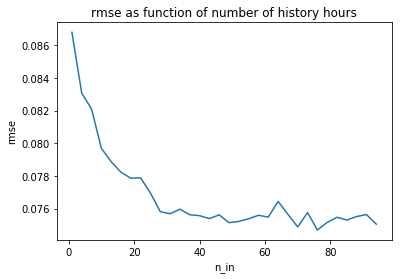

In [0]:
path = './models_weights/'
desc = '_best_n_in'
res, best_m = nn_by_history_in([i for i in range(1,96,3)],path,desc)

in this plot we can notice that for different n_in we got different rmse, the lowest rmse we got for 76 n_in.  
let's check the rmse:

In [0]:
best_m.load_weights('./models_weights/_best_n_in_76/best_weights.hdf5')
validation_X,validation_Y = to_supervised(validation_normalized,76)
nn_pred = best_m.predict(np.asarray(validation_X))
rmse(validation_Y,nn_pred)

0.0746921123307941

the last result was depend on n_in let's get result for our test set:

In [0]:
best_m.load_weights('./models_weights/_best_n_in_76/best_weights.hdf5')
X,Y = to_supervised(test_data_normalized,76)
rmse(Y,best_m.predict(np.asarray(X)))

0.07512431310332386

as we can see we have got higher rmse than in the validation set. but the gap is very small.  
we improved the rmse from 0.0763 to 0.0751 ,*** so our new benchmark is 0.0751 ***

In [0]:
n_in=76; path = './models_weights/_best_n_in_76/best_weights.hdf5'
analyze_result(model,path,n_in)

,hour,count
0,19,8
1,18,8
2,12,7
3,14,4
4,21,3
5,20,3
6,11,3
7,10,3
8,22,2
9,17,2


,0
pm,35
am,14


,day,count
0,Saturday,12
1,Sunday,11
2,Wednesday,8
3,Monday,8
4,Thursday,5
5,Tuesday,4
6,Friday,1


* there are only 49 errors.  
* 70% at pm.
* 26% during weekend.  
in compare to the last model there are only 49 errors with 0.2 above the rmse (54 in last model),
most of the errors are still at pm, but the number of errors during the weekend dropped from 40% to 26%. so by this model we improved the weekend prediction.

## deeper nn using 1D cnn  
now we try to use Conv1D in order to recognize patterns in the data, we also use LSTM to study and 'remember' these sequence of patterns. we use dropout because the number of parameters is very high and we dont want to overfit the data.

In [0]:
def build_nn_model_v2(n_in,n_out,n_vars):
    inp = Input(shape=(n_in,n_vars))
    x = Conv1D(64,3)(inp)
    x = Dropout(0.1)(x)
    x = LSTM(40, return_sequences = False)(x)
    output = Dense(n_out)(x)
    model = Model(inp,output)
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.summary()
    return model

_path = './models_weights/'
_description = '_CNN_new16'
n_out = 1
n_in = 76 
n_vars=validation_normalized.shape[1]

# series to supervised
validation_X,validation_Y = to_supervised(validation_normalized,n_in)
train_X,train_Y = to_supervised(train_normalized,n_in)

# build NN model
model = build_nn_model_v2(n_in,n_out,n_vars)

# fit the model
history = model.fit(np.asarray(train_X),np.asarray(train_Y),validation_data=[np.asarray(validation_X),np.asarray(validation_Y)],
          callbacks = set_callbacks(patience=5, path=_path , description=_description + '_' + str(n_in) + '_new'),epochs=13,batch_size=32) 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 76, 7)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 74, 64)            1408      
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 64)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 40)                16800     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 41        
Total params: 18,249
Trainable params: 18,249
Non-trainable params: 0
_________________________________________________________________
Train on 21586 samples, validate on 5339 samples
Epoch 1/13
21586/21586 [==============================] - 54s 3ms/step - loss: 0.0117 - v

In [0]:
save_obj(history.history,'./models_weights/_CNN_new6_76_new/history')

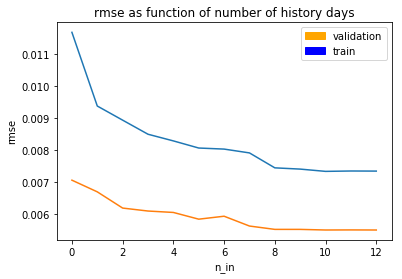

In [0]:
plot_loss(history.history)

as we can see in this plot until epoch 8 as long as the train loss decrease the validation loss decrease as well, from this epoch the loss is constant and the model doesn't success to fit the train better.

let's look at the rmse on the validation set:

In [0]:
model.load_weights('./models_weights/_CNN_new16_76_new/weights.11-0.01__CNN_new16_76_new.hdf5')
n_in=76
validation_X,validation_Y = to_supervised(validation_normalized,n_in)
nn_pred = model.predict(np.asarray(validation_X))
rmse(validation_Y,nn_pred)

0.07419044963802596

this result looks great, but it depend on the loss of the validation set, we chose the model with the lowest validation lose. let's see if the situation with the rmse of the test set is similar:

In [0]:
X,Y = to_supervised(test_data_normalized,n_in)
rmse(Y,model.predict(np.asarray(X)))

0.07668591072075313

the rmse of the test set is not improve our last benchmark. this can be because of we chose the weights of the lowest loss, so the model we get is depend on the loss rate and has really nice loss and rmse result, but when we calculate rmse on test set that doesnt depend on any variable we see that this model fitted better the validation set than other models but it is not generalize emough because the rmse of the test set is higher than the previous models.

In [0]:
n_in=76; path = './models_weights/_CNN_new16_76_new/weights.11-0.01__CNN_new16_76_new.hdf5'
analyze_result(model,path,n_in)

,hour,count
0,19,8
1,12,7
2,18,6
3,20,4
4,14,4
5,11,4
6,21,3
7,17,2
8,15,2
9,13,2


,0
pm,33
am,18


,day,count
0,Saturday,15
1,Sunday,10
2,Wednesday,9
3,Monday,8
4,Thursday,5
5,Tuesday,3
6,Friday,1


total number of errors: 51  
at pm 64%  
at weekend 49%  
  
this model is not better than the previous models in this aspects and the using of cnn with lstm didn't help us in this case.

*** what can we do more?  ***  
the result we have got is pretty good, a good way to improve it can be by recognize patterns by training Conv1D and use the result as features for classic model. (we didn't try this because we did something similar in the last assignment and we wanted to try to get experience with different directions, and because in the last model it looks like conv1D doesnt help us.) or maybe try to get deeper and know better the data, in order to make feature engineering that can lead help the model to learn the data better.

# SUMMARY  
we trained 6 different models, here we will write briefly the results on the test set:  

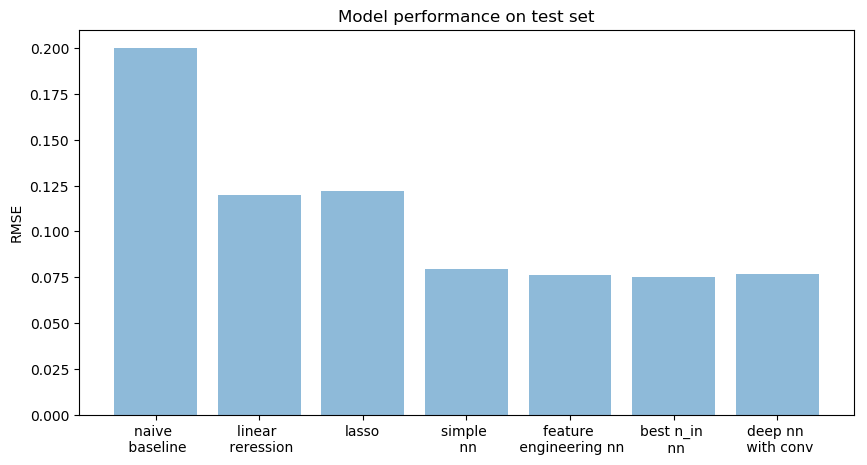

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('naive \n baseline', 'linear \n reression', 'lasso', 'simple \n nn', 'feature \n engineering nn', 'best n_in \n nn', 'deep nn \n with conv')
y_pos = np.arange(len(objects))
performance = [0.200,0.1197,0.122,0.0797,0.0763,0.0751,0.0766]
plt.figure(figsize=(10,5))
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.title('Model performance on test set')

plt.show()


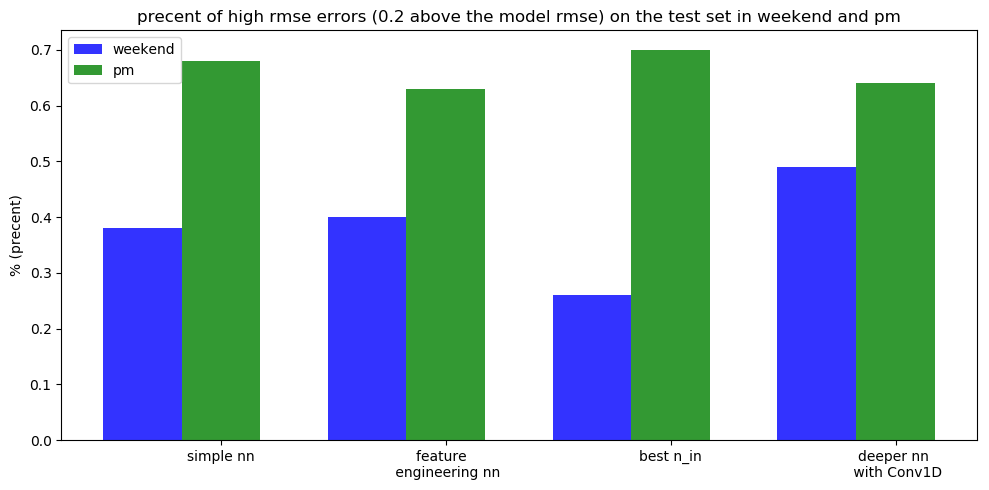

In [0]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 4
pm = (0.68, 0.63, 0.7, 0.64)
weekend = (0.38, 0.4, 0.26, 0.49)

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, weekend, bar_width,
                 alpha=opacity,
                 color='b',
                 label='weekend')
 
rects2 = plt.bar(index + bar_width, pm, bar_width,
                 alpha=opacity,
                 color='g',
                 label='pm')

plt.ylabel('% (precent)')
plt.title('precent of high rmse errors (0.2 above the model rmse) on the test set in weekend and pm')
plt.xticks(index + bar_width, ('simple nn', 'feature  \n engineering nn', 'best n_in', 'deeper nn \n with Conv1D'))
plt.legend() 
plt.tight_layout()

plt.show()